### ***IMPORTS***

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Kraus, SuperOp, DensityMatrix, partial_trace, Operator, state_fidelity
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error)

from numpy import pi, cos, sin
import numpy as np
import matplotlib.pyplot as plt
import pickle, glob


### ***Helper fns and dict loads***

In [ ]:
'''helper functions'''

def _eec_inst_for(per, eec_dict, label):
    """ takes physical error rate and dict as input, returns Qiskit instruction"""
    if per not in eec_dict:
        raise KeyError(f"Physical error rate {per} not found in {label} dictionary.")
    eec = eec_dict[per][-1]                # last element is the QuantumError channel
    inst = eec.to_instruction() if hasattr(eec, "to_instruction") else eec
    inst.name = f"{label}({per})"
    return inst

def cx_with_eec(qc, ctrl, targ, cx_eec_inst):
    qc.cx(ctrl, targ)
    qc.append(cx_eec_inst, [ctrl, targ])
    return qc

In [31]:
''' load dictionaries '''
def load_latest(name):
    # obtain all matching pickle files
    files = sorted(glob.glob(f"{name}_*.pkl"))
    if not files:
        raise FileNotFoundError(f"No saved files found for {name}")
    latest_file = files[-1]  # last in sorted list = newest (since timestamp in name)
    print(f"{latest_file} loaded")
    with open(latest_file, "rb") as f:
        return pickle.load(f)

# --- load relevant dictionaries ---
# injection_eec_alltrials = load_latest("injection_eec_alltrials")
# cnot_eec_alltrials = load_latest("cnot_eec_alltrials")
injection_eec_smallp = load_latest("injection_eec_smallp")
cnot_eec_smallp = load_latest("cnot_eec_smallp_updated")

injection_eec_smallp_20250811-074811.pkl loaded
cnot_eec_smallp_updated_20250811-080625.pkl loaded


### ***DEFINE CIRCUIT***

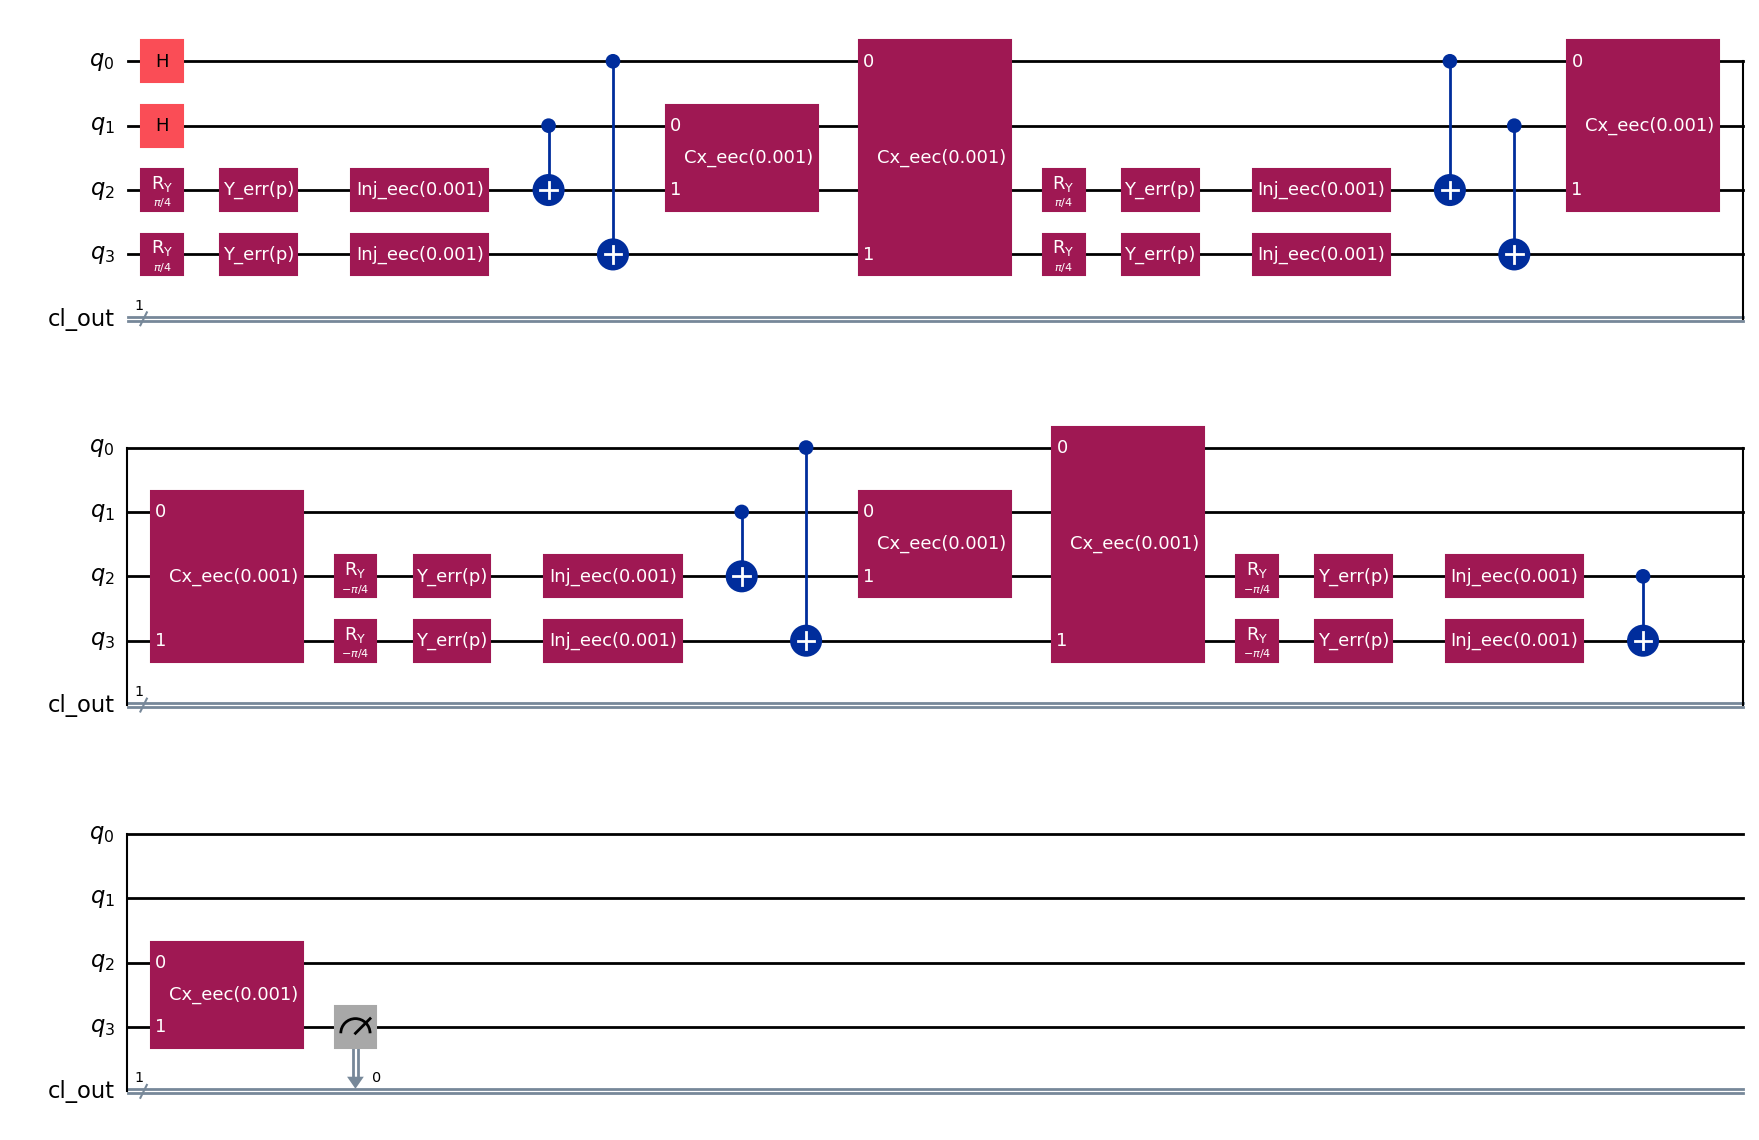

In [ ]:
'''Distillation circuit where Y(pi/4) rotations are implemented directly. 
This can be done since a Y-error on an inputted |H> in the injection subcircuit propogates directly to the injected data qubit, which realizes the Y(pi/4)'''

def noisy_y_pi4(qc, q_num, sign, yer, inj_eec_inst):
    qc.ry(sign * pi/4, q_num)  # rotation around y-axis by pi/4, equals |H> (see notes)
    y_err = pauli_error([('Y', yer), ('I', 1-yer)])      # ref: https://bit.ly/3GtQ8Nl
    y_err_channel = y_err.to_instruction()               # cast as an error channel
    y_err_channel.name = 'Y_err(p)'
    qc.append(y_err_channel, [q_num])
    qc.append(inj_eec_inst, [q_num])                     # apply effective injection channel (from dict)
    return qc


def distillation(yer, per, inj_dict=None, cx_dict=None):
    '''Eastin Figure 4 H-to-Toffoli distillation with added EECs;
       yer is y-error probability for injected |H> states (as in Eastin paper),
       per is physical Clifford error rate from which we constructed our EECs'''

    # default to global dictionaries
    # inj_dict = injection_eec_alltrials if inj_dict is None else inj_dict
    # cx_dict  = cnot_eec_alltrials     if cx_dict  is None else cx_dict
    inj_dict = injection_eec_smallp if inj_dict is None else inj_dict
    cx_dict  = cnot_eec_smallp    if cx_dict  is None else cx_dict

    # fetch EEC instructions
    inj_eec_inst = _eec_inst_for(per, inj_dict, "inj_EEC")
    cx_eec_inst  = _eec_inst_for(per, cx_dict,  "cx_EEC")

    # registers
    data  = QuantumRegister(4, 'q')
    cl_out = ClassicalRegister(1, 'cl_out')
    qc = QuantumCircuit(data, cl_out)

    # init
    qc.h(data[0])
    qc.h(data[1])
    noisy_y_pi4(qc, data[2], +1, yer, inj_eec_inst)
    noisy_y_pi4(qc, data[3], +1, yer, inj_eec_inst)

    # circuit body
    cx_with_eec(qc, data[1], data[2], cx_eec_inst)
    cx_with_eec(qc, data[0], data[3], cx_eec_inst)
    noisy_y_pi4(qc, data[2], +1, yer, inj_eec_inst)
    noisy_y_pi4(qc, data[3], +1, yer, inj_eec_inst)

    cx_with_eec(qc, data[0], data[2], cx_eec_inst)
    cx_with_eec(qc, data[1], data[3], cx_eec_inst)
    noisy_y_pi4(qc, data[2], -1, yer, inj_eec_inst)
    noisy_y_pi4(qc, data[3], -1, yer, inj_eec_inst)

    cx_with_eec(qc, data[1], data[2], cx_eec_inst)
    cx_with_eec(qc, data[0], data[3], cx_eec_inst)
    noisy_y_pi4(qc, data[2], -1, yer, inj_eec_inst)
    noisy_y_pi4(qc, data[3], -1, yer, inj_eec_inst)

    # final measurement
    cx_with_eec(qc, data[2], data[3], cx_eec_inst)
    qc.measure(data[3], cl_out[0])

    return qc


# qc = distillation(yer=0.001, per=0.15)
qc = distillation(yer=0.001, per=0.001)
qc.draw('mpl')

## ***PLOTS WITH EECs***

### ***a(p) with EECs***

per value: 0
per value: 0.001
per value: 0.003
per value: 0.005


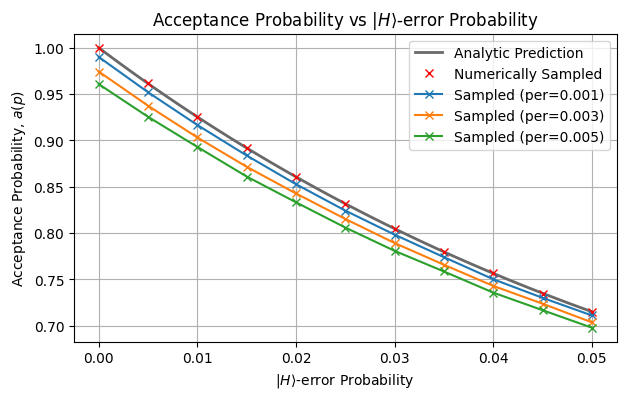

In [ ]:
def acceptance_prob_analytic(yer):
    yer = np.asarray(yer)
    return (1 - 8*yer + 56*yer**2 - 224*yer**3 + 560*yer**4
            - 896*yer**5 + 896*yer**6 - 512*yer**7 + 128*yer**8)

def acceptance_prob(nshots, yer, per):
    """ simulate acceptance probability for given |H> y-error prob (yer) and Clifford-error prob (per)"""
    qc = distillation(yer=yer, per=per)  # your updated distillation uses p for Y-error prob
    sim = AerSimulator()
    result = sim.run(transpile(qc, sim), shots=nshots).result()
    counts = result.get_counts(qc)
    zeros = sum(c for bits, c in counts.items() if bits.split()[0] == '0')
    return zeros / nshots

nshots = 500_000
yer_grid = np.linspace(0, 0.05, 11)
per_values = [0, 0.001, 0.003, 0.005]  

accept_curves = {}
for per in per_values:
    print(f'per value: {per}')
    accept_curves[per] = [acceptance_prob(nshots, yer, per) for yer in yer_grid]

# --- plot ---
plt.figure(figsize=(7,4))
yer_fine = np.linspace(0, 0.05, 100)
plt.plot(yer_fine, acceptance_prob_analytic(yer_fine), linewidth=2, color='dimgrey', label='Analytic Prediction')

# sampled curves for each EEC rate
for per, acc in accept_curves.items():
    if per == 0:
        plt.plot(yer_grid, acc, marker='x', linestyle='', color='red', label=f'Numerically Sampled')
        continue  # skip plotting per = 0
    plt.plot(yer_grid, acc, marker='x', linestyle='-', label=f'Sampled (per={per})')

plt.title(r'Acceptance Probability vs $|H\rangle$-error Probability')
plt.xlabel(r'$|H\rangle$-error Probability')
plt.ylabel(r'Acceptance Probability, $a(p)$')
plt.grid(True)
plt.legend()



### ***u(p) with EECs***

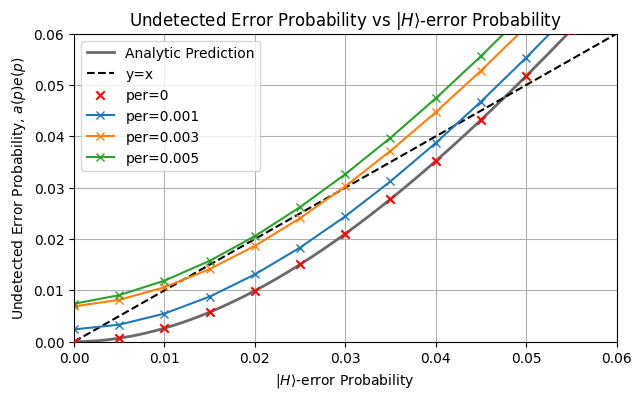

In [ ]:
def error_prob_analytic(yer):
    yer = np.asarray(yer)
    return (28*yer**2 - 168*yer**3 + 476*yer**4 - 784*yer**5
            + 784*yer**6 - 448*yer**7 + 112*yer**8)

def error_prob(yer, per):
    # target Toffoli state (ENDIAN ORDERING!)
    toffoli_psi = np.array([0.5, 0.5, 0.5, 0, 0, 0, 0, 0.5], dtype=complex)
    toffoli_dm = np.outer(toffoli_psi, toffoli_psi.conj())

    # build circuit and remove the final measurement
    qc = distillation(yer=yer, per=per)  
    qc_copy = QuantumCircuit(*qc.qregs)
    for inst in qc.data:
        if inst.operation.name != 'measure':
            qc_copy.append(inst.operation, inst.qubits, inst.clbits)

    # simulate and get final density matrix
    qc_copy.save_density_matrix(label='rho')
    sim = AerSimulator(method='density_matrix')
    result = sim.run(transpile(qc_copy, sim)).result()
    rho_full = result.data(0)['rho']  # 16x16 ndarray (4 qubits)

    rho_obj = result.data(0)['rho']
    rho_full = rho_obj.data if hasattr(rho_obj, 'data') else rho_obj
    
    # projector onto acceptance on the measured qubit q3 (ENDIAN!)
    P0 = Operator([[1,0],[0,0]])
    I2 = Operator(np.eye(2))
    P_acc = (P0.tensor(I2).tensor(I2).tensor(I2)).data  

    # project, renormalize
    rho_acc = P_acc @ rho_full @ P_acc.conj().T
    sim_acc = np.real(np.trace(rho_acc))
    if sim_acc > 0:
        rho_acc = rho_acc / sim_acc

    # trace out the measured flag qubit (q3), obtain final 3-qubit state
    rho_final = partial_trace(DensityMatrix(rho_acc), [3]).data

    # fidelity and undetected error prob
    fidelity = state_fidelity(rho_final, toffoli_dm)
    sim_error = abs(1 - fidelity)
    sim_ae = sim_acc * sim_error

    theory = float(error_prob_analytic(yer))
    return sim_ae, theory

# ---- sweep yer and plot multiple per lines ----
yer_grid = np.linspace(0, 0.1, 21)
per_values = [0, 0.001, 0.003, 0.005]   
# per_values = [0,]   

curves = {}
for per in per_values:
    curves[per] = [error_prob(yer, per)[0] for yer in yer_grid]

# --- plot ---
plt.figure(figsize=(7,4))
yer_fine = np.linspace(0, 0.5, 400)
plt.plot(yer_fine, error_prob_analytic(yer_fine), linewidth=2, color='dimgrey', label='Analytic Prediction')
plt.plot(yer_fine, yer_fine, 'k--', label='y=x')

for per, vals in curves.items():
    if per == 0:
        # points only so it doesn't cover the theory line
        plt.scatter(yer_grid, vals, marker='x', color='red', label='per=0', zorder=3)
    else:
        # line + points for other per values
        plt.plot(yer_grid, vals, marker='x', linestyle='-', label=f'per={per}', zorder=2)
plt.title(r'Undetected Error Probability vs $|H\rangle$-error Probability')
plt.xlabel(r'$|H\rangle$-error Probability')
plt.ylabel(r'Undetected Error Probability, $a(p)e(p)$')
plt.grid(True)
plt.legend()
plt.xlim(0, 0.06)
plt.ylim(0, 0.06)
plt.show()

## ***PLOTS WITHOUT EECs***

### ***a(p) without EECs***

per value: 0


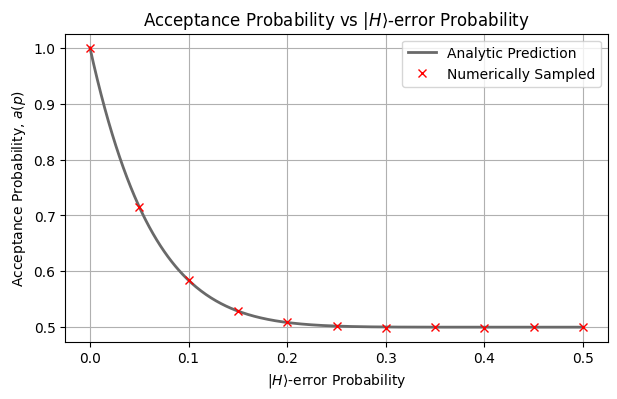

In [ ]:
''' code for a(p) logical circuit '''
def acceptance_prob_analytic(yer):
    yer = np.asarray(yer)
    return (1 - 8*yer + 56*yer**2 - 224*yer**3 + 560*yer**4
            - 896*yer**5 + 896*yer**6 - 512*yer**7 + 128*yer**8)

def acceptance_prob(nshots, yer, per):
    """simulate acceptance probability for given Y-error prob 'yer` and EEC physical rate `per`."""
    qc = distillation(yer=yer, per=per)  # your updated distillation uses p for Y-error prob
    sim = AerSimulator()
    result = sim.run(transpile(qc, sim), shots=nshots).result()
    counts = result.get_counts(qc)
    zeros = sum(c for bits, c in counts.items() if bits.split()[0] == '0')
    return zeros / nshots

# params
nshots = 500_000
yer_grid = np.linspace(0, 0.5, 11)          # Y-error probabilities to sample
per_values = [0]                            # EEC physical error rates to compare


accept_curves = {}
for per in per_values:
    print(f'per value: {per}')
    accept_curves[per] = [acceptance_prob(nshots, yer, per) for yer in yer_grid]

# --- plot ---
plt.figure(figsize=(7,4))
yer_fine = np.linspace(0, 0.5, 400)
plt.plot(yer_fine, acceptance_prob_analytic(yer_fine), linewidth=2, color='dimgrey', label='Analytic Prediction')

# sampled curves for each EEC rate
for per, acc in accept_curves.items():
    if per == 0:
        plt.plot(yer_grid, acc, marker='x', linestyle='', color='red', label=f'Numerically Sampled')
        continue  # skip plotting per = 0
    plt.plot(yer_grid, acc, marker='x', linestyle='-', label=f'Sampled (per={per})')

plt.title(r'Acceptance Probability vs $|H\rangle$-error Probability')
plt.xlabel(r'$|H\rangle$-error Probability')
plt.ylabel(r'Acceptance Probability, $a(p)$')
plt.grid(True)
plt.legend()
plt.plot()



### ***u(p) without EECs***

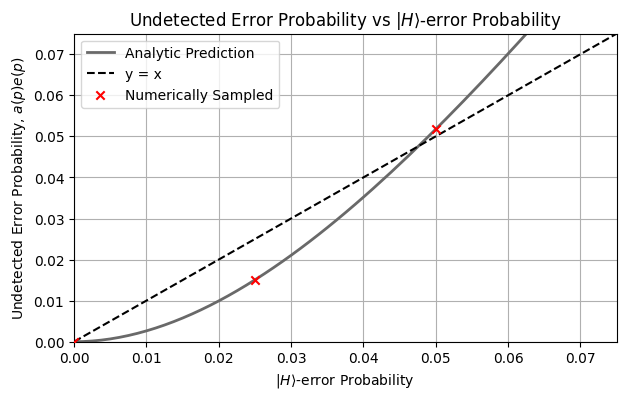

In [ ]:
''' code for uep logical circuit'''

def error_prob_analytic(yer):
    yer = np.asarray(yer)
    return (28*yer**2 - 168*yer**3 + 476*yer**4 - 784*yer**5
            + 784*yer**6 - 448*yer**7 + 112*yer**8)

def error_prob(yer, per):
    # target Toffoli state (ENDIAN ORDERING!)
    toffoli_psi = np.array([0.5, 0.5, 0.5, 0, 0, 0, 0, 0.5], dtype=complex)
    toffoli_dm = np.outer(toffoli_psi, toffoli_psi.conj())

    # build circuit and remove the final measurement
    qc = distillation(yer=yer, per=per)  
    qc_copy = QuantumCircuit(*qc.qregs)
    for inst in qc.data:
        if inst.operation.name != 'measure':
            qc_copy.append(inst.operation, inst.qubits, inst.clbits)

    # simulate and get final density matrix
    qc_copy.save_density_matrix(label='rho')
    sim = AerSimulator(method='density_matrix')
    result = sim.run(transpile(qc_copy, sim)).result()
    rho_full = result.data(0)['rho']  # 16x16 ndarray (4 qubits)

    rho_obj = result.data(0)['rho']
    rho_full = rho_obj.data if hasattr(rho_obj, 'data') else rho_obj

    # projector onto acceptance on the measured qubit q3 (ENDIAN!)
    P0 = Operator([[1,0],[0,0]])
    I2 = Operator(np.eye(2))
    P_acc = (P0.tensor(I2).tensor(I2).tensor(I2)).data  # use .data for ndarray math

    # project, renormalize
    rho_acc = P_acc @ rho_full @ P_acc.conj().T
    sim_acc = np.real(np.trace(rho_acc))
    if sim_acc > 0:
        rho_acc = rho_acc / sim_acc

    # trace out the measured qubit (q3) → final 3-qubit state
    rho_final = partial_trace(DensityMatrix(rho_acc), [3]).data

    # fidelity and undetected error
    fidelity = state_fidelity(rho_final, toffoli_dm)
    sim_error = abs(1 - fidelity)
    sim_ae = sim_acc * sim_error

    theory = float(error_prob_analytic(yer))
    return sim_ae, theory

# params
yer_grid = np.linspace(0, 0.5, 21)
per_values = [0]  
curves = {}
for per in per_values:
    curves[per] = [error_prob(yer, per)[0] for yer in yer_grid]

# --- plot ---
plt.figure(figsize=(7,4))
yer_fine = np.linspace(0, 0.5, 400)
plt.plot(yer_fine, error_prob_analytic(yer_fine), linewidth=2, color='dimgrey', label='Analytic Prediction')
plt.plot(yer_fine, yer_fine, 'k--', label='y = x')


for per, vals in curves.items():
    if per == 0:
        # points only so it doesn't cover the theory line
        plt.scatter(yer_grid, vals, marker='x', color='red', label='Numerically Sampled', zorder=3)
    else:
        # line + points for other per values
        plt.plot(yer_grid, vals, marker='x', linestyle='-', label=f'Sim (per={per})', zorder=2)
plt.title(r'Undetected Error Probability vs $|H\rangle$-error Probability')
plt.xlabel(r'$|H\rangle$-error Probability')
plt.ylabel(r'Undetected Error Probability, $a(p)e(p)$')
plt.grid(True)
plt.legend()
plt.xlim(0, 0.075)
plt.ylim(0, 0.075)
plt.show()